In [1]:
%pip install --quiet qutip qutip-qip qiskit qiskit-aer pylatexenc pandas seaborn &> /dev/null

Note: you may need to restart the kernel to use updated packages.


In [1]:
import qutip as qt
from qutip import Qobj
from qiskit import QuantumCircuit, QuantumRegister
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import *
from qiskit.quantum_info import Operator, process_fidelity, Choi, Operator, DensityMatrix, Kraus, SuperOp, Pauli

import pandas as pd
import numpy as np
from scipy.linalg import polar, logm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product

In [2]:
sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
I = qt.qeye(2)

paulis = [I, sx, sy, sz]
pauli_labels = ['I', 'X', 'Y', 'Z']

In [3]:
def pulse_shape(shape="cos", A=1.0, delta=0.0, sigma=0.1, alpha=0.5, chirp_rate=0.0):

    if shape == "cos":
        return lambda t, args: A * np.cos(delta * t)

    elif shape == "gaussian":
        return lambda t, args: A * np.exp(-((t - 0.5)**2) / (2 * sigma**2))

    elif shape == "square":
        return lambda t, args: A if 0.3 <= t <= 0.7 else 0.0

    elif shape == "chirp":
        return lambda t, args: A * np.cos((delta + chirp_rate * t) * t)

    elif shape == "drag":
        return lambda t, args: A * (np.exp(-((t - 0.5)**2)/(2 * sigma**2))
                                   - alpha * (t - 0.5) / sigma**2 * np.exp(-((t - 0.5)**2)/(2 * sigma**2)))

    else:
        raise ValueError(f"Unknown pulse shape: {shape}")


In [4]:
def apply_eve_multi_attack(state_pre, J12=0.5, J01=0.5, A=(1.0, 1.0),
                            delta=(0.0, 0.0), coup_12=(qt.sigmaz(), qt.sigmax()),
                            coup_01=(qt.sigmaz(), qt.sigmax()),
                            shape=("cos", "cos"),
                            extra_params=({}, {})):
    A0, A1 = A
    delta0, delta1 = delta
    s1_12, s2_12 = coup_12
    s0_01, s1_01 = coup_01
    shape0, shape1 = shape
    kwargs0, kwargs1 = extra_params

    I = qt.qeye(2)

    # Coupling terms
    H_couple_12 = J12 * qt.tensor(I, s1_12, s2_12)
    H_couple_01 = J01 * qt.tensor(s0_01, s1_01, I)

    # Time-dependent drive terms
    coeff0 = pulse_shape(shape=shape0, A=A0, delta=delta0, **kwargs0)
    coeff1 = pulse_shape(shape=shape1, A=A1, delta=delta1, **kwargs1)

    H_p0 = [qt.tensor(qt.sigmax(), I, I), coeff0]
    H_p1 = [qt.tensor(I, qt.sigmax(), I), coeff1]

    H = [H_couple_12, H_couple_01, H_p0, H_p1]

    t_attack = np.linspace(0, 1.0, 50)
    sol = qt.mesolve(H, state_pre, t_attack, [], [])
    return sol.states[-1]


Coin Flip

In [5]:
def build_coinflip_state(theta):
    psi = (np.cos(theta) * qt.basis(2, 0) + np.sin(theta) * qt.basis(2, 1)).unit()
    zero = qt.basis(2, 0)
    return qt.tensor(zero, zero, psi)

def Ry(theta):
    return qt.Qobj([[np.cos(theta/2), -np.sin(theta/2)],
                    [np.sin(theta/2),  np.cos(theta/2)]])

In [6]:
def measure_coinflip_with_attack(theta, J12=0.5, J01=0.5, A=(0.5, 0.5),
                                 delta=(0.0, 0.0),
                                 coup_12=(qt.sigmaz(), qt.sigmax()),
                                 coup_01=(qt.sigmaz(), qt.sigmax()),
                                 shape=("cos", "cos"),
                                 extra_params=({}, {})):

    state_init = build_coinflip_state(theta)
    state_post = apply_eve_multi_attack(
        state_init,
        J12=J12, J01=J01,
        A=A, delta=delta,
        coup_12=coup_12, coup_01=coup_01,
        shape=shape, extra_params=extra_params
    )
    state_q2 = state_post.ptrace(2)
    P_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    prob_1 = qt.expect(P_1, state_q2)
    return prob_1

In [7]:
def measure_coinflip_biased_init(theta, J12=0.5, J01=0.5, A=(0.5, 0.5),
                                 delta=(0.0, 0.0),
                                 coup_12=(qt.sigmaz(), qt.sigmax()),
                                 coup_01=(qt.sigmaz(), qt.sigmax()),
                                 shape=("cos", "cos"),
                                 extra_params=({}, {})):
    # 1. Start with |0>⊗|0>⊗|0>
    zero = qt.basis(2, 0)
    state_init = qt.tensor(zero, zero, zero)

    # 2. Apply Eve's pulse injection (bias) first
    state_biased = apply_eve_multi_attack(
        state_init,
        J12=J12, J01=J01,
        A=A, delta=delta,
        coup_12=coup_12, coup_01=coup_01,
        shape=shape, extra_params=extra_params
    )

    # 3. Apply victim's coin flip: acts only on q2
    Ry_lambda = Ry(theta)
    I_q0 = qt.qeye(2)
    I_q1 = qt.qeye(2)
    U_victim = qt.tensor(I_q0, I_q1, Ry_lambda)

    state_post = U_victim * state_biased

    # 4. Trace out Eve’s qubits
    state_q2 = state_post.ptrace(2)

    # 5. Compute P(|1>)
    P_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    prob_1 = qt.expect(P_1, state_q2)

    return prob_1


/Users/syedshubha/mambaforge/lib/python3.13/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


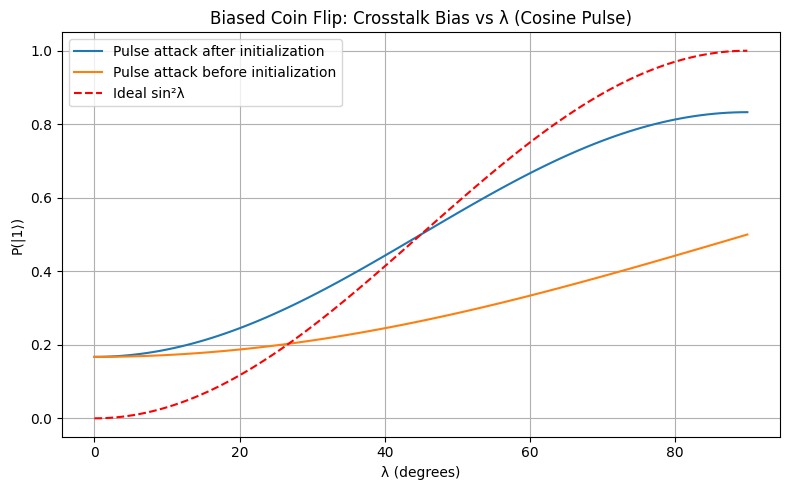

In [8]:
theta_vals = np.linspace(0, np.pi/2, 100)
probs_attack1 = []
probs_attack2 = []
probs_ideal = []

theta_vals = np.linspace(0, np.pi/2, 100)
probs_attack = []
probs_ideal = []

for theta in theta_vals:
    # With attack
    p1 = measure_coinflip_with_attack(theta)
    probs_attack1.append(p1)

    p2 = measure_coinflip_biased_init(theta)
    probs_attack2.append(p2)

    # Ideal (no attack)
    p1_ideal = np.sin(theta)**2
    probs_ideal.append(p1_ideal)

plt.figure(figsize=(8, 5))
plt.plot(theta_vals * 180/np.pi, probs_attack1, label="Pulse attack after initialization")
plt.plot(theta_vals * 180/np.pi, probs_attack2, label="Pulse attack before initialization")
plt.plot(theta_vals * 180/np.pi, probs_ideal, '--', label="Ideal sin²λ", color='red')
plt.xlabel("λ (degrees)")
plt.ylabel("P(|1⟩)")
plt.title("Biased Coin Flip: Crosstalk Bias vs λ (Cosine Pulse)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("BiasedCoinFlipCosine.png", dpi=1000)
plt.savefig("BiasedCoinFlip.svg")
plt.show()

/Users/syedshubha/mambaforge/lib/python3.13/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


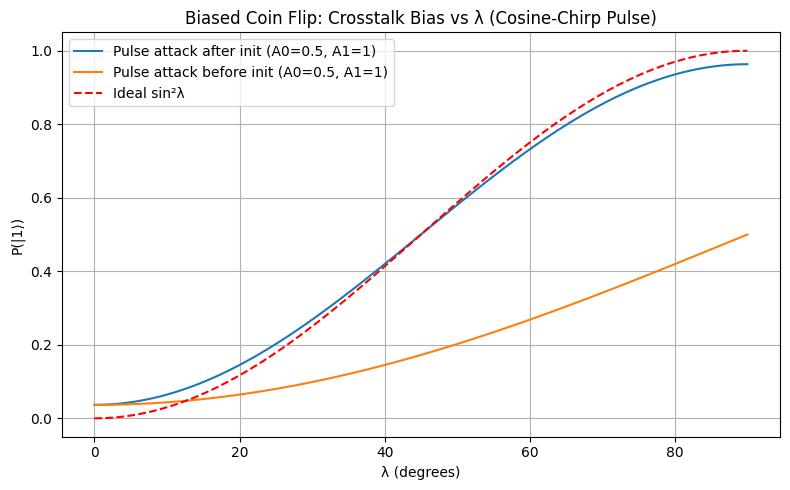

In [12]:
A0 = 0.5  
A1 = 1  

theta_vals = np.linspace(0, np.pi/2, 100)
probs_attack1 = []
probs_attack2 = []
probs_ideal = []

for theta in theta_vals:
    # With attack (AFTER initialization)
    p1 = measure_coinflip_with_attack(
        theta,
        J12=0.2, J01=0.1,
        A=(A0, A1),        # <---- HERE
        delta=(0.0, 0.0),
        coup_12=(qt.sigmaz(), qt.sigmax()),
        coup_01=(qt.sigmaz(), qt.sigmax()),
        shape=("cos", "chirp"),
        extra_params=({}, {"chirp_rate": 5.0})
    )
    probs_attack1.append(p1)

    # With attack (BEFORE initialization)
    p2 = measure_coinflip_biased_init(
        theta,
        J12=0.2, J01=0.1,
        A=(A0, A1),        # <---- HERE
        delta=(0.0, 0.0),
        coup_12=(qt.sigmaz(), qt.sigmax()),
        coup_01=(qt.sigmaz(), qt.sigmax()),
        shape=("cos", "chirp"),
        extra_params=({}, {"chirp_rate": 5.0})
    )
    probs_attack2.append(p2)

    # Ideal (no attack)
    p1_ideal = np.sin(theta)**2
    probs_ideal.append(p1_ideal)

plt.figure(figsize=(8, 5))
plt.plot(theta_vals * 180/np.pi, probs_attack1, label=f"Pulse attack after init (A0={A0}, A1={A1})")
plt.plot(theta_vals * 180/np.pi, probs_attack2, label=f"Pulse attack before init (A0={A0}, A1={A1})")
plt.plot(theta_vals * 180/np.pi, probs_ideal, '--', label="Ideal sin²λ", color='red')
plt.xlabel("λ (degrees)")
plt.ylabel("P(|1⟩)")
plt.title("Biased Coin Flip: Crosstalk Bias vs λ (Cosine-Chirp Pulse)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"BiasedCoinFlipCosine_A0_{A0}_A1_{A1}.png", dpi=1000)
plt.savefig(f"BiasedCoinFlip_A0_{A0}_A1_{A1}.svg")
plt.show()


XOR

In [10]:
# --- 1. Logical XOR unitary ---
def build_XOR_logical(x1, x2, theta1=np.pi, theta2=np.pi, alpha=-np.pi/2):
    # 1 qubit only for the logical qubit
    H = (sx + sz) / np.sqrt(2)
    RZ = (-1j * sz * (x1 * theta1 + alpha) / 2).expm()
    RX = (-1j * sx * (x2 * theta2 + alpha) / 2).expm()
    U = RX @ RZ @ H
    return U

# --- 2. Embed into larger system: Eve attacks ---
def build_full_XOR_state():
    # Eve has q0, q1; logical is q2
    zero = qt.basis(2, 0)
    psi = qt.tensor(zero, zero, zero)
    return psi

# --- 3. Apply attack before logical unitary ---
def apply_attack_then_XOR(x1, x2, J12=0.5, J01=0.5, A=(0.5, 0.5),
                          delta=(0.0, 0.0),
                          coup_12=(sz, sx), coup_01=(sz, sx),
                          shape=("cos", "cos"), extra_params=({}, {})):
    psi_init = build_full_XOR_state()
    psi_after_attack = apply_eve_multi_attack(
        psi_init, J12=J12, J01=J01, A=A, delta=delta,
        coup_12=coup_12, coup_01=coup_01,
        shape=shape, extra_params=extra_params
    )

    # Logical XOR unitary on q2
    U_logical = build_XOR_logical(x1, x2)
    U_logical_full = qt.tensor(I, I, U_logical)
    psi_final = U_logical_full * psi_after_attack

    rho = psi_final * psi_final.dag()
    rho_q2 = rho.ptrace(2)
    P1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    prob_1 = qt.expect(P1, rho_q2)
    return prob_1

# --- 4. Or: Attack after logical unitary ---
def apply_XOR_then_attack(x1, x2, J12=0.2, J01=0.1, A=(0.5, 1),
                          delta=(0.0, 0.0),
                          coup_12=(sz, sx), coup_01=(sz, sx),
                          shape=("cos", "chirp"), extra_params=({}, {})):
    psi_init = build_full_XOR_state()

    # Logical XOR unitary first
    U_logical = build_XOR_logical(x1, x2)
    U_logical_full = qt.tensor(I, I, U_logical)
    psi_after_logical = U_logical_full * psi_init

    psi_after_attack = apply_eve_multi_attack(
        psi_after_logical, J12=J12, J01=J01, A=A, delta=delta,
        coup_12=coup_12, coup_01=coup_01,
        shape=shape, extra_params=extra_params
    )

    rho = psi_after_attack * psi_after_attack.dag()
    rho_q2 = rho.ptrace(2)
    P1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    prob_1 = qt.expect(P1, rho_q2)
    return prob_1


In [11]:
x_pairs = [(0,0), (0,1), (1,0), (1,1)]
ideal = []
attack_before = []
attack_after = []

for x1, x2 in x_pairs:
    # Ideal circuit
    U = build_XOR_logical(x1, x2)
    psi = qt.basis(2,0)
    psi_final = U * psi
    rho = psi_final * psi_final.dag()
    P1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    p_ideal = qt.expect(P1, rho)
    ideal.append(p_ideal)

    # With attacks
    p_b = apply_attack_then_XOR(x1, x2)
    p_a = apply_XOR_then_attack(x1, x2)
    attack_before.append(p_b)
    attack_after.append(p_a)

print("Inputs:", x_pairs)
print("Ideal:", ideal)
print("Before attack:", attack_before)
print("After attack:", attack_after)


Inputs: [(0, 0), (0, 1), (1, 0), (1, 1)]
Ideal: [0.0, 0.9999999999999998, 0.9999999999999998, 0.0]
Before attack: [0.16717878733327016, 0.8328212126667296, 0.8328212126667296, 0.16717878733327016]
After attack: [0.026164485148625207, 0.9738355148513748, 0.9738355148513748, 0.026164485148625207]


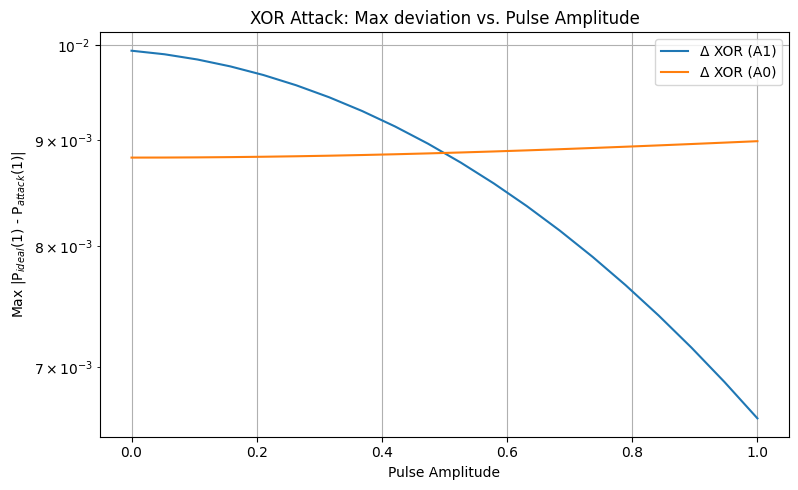

In [12]:
# Single-qubit RX rotation: Rₓ(θ) = exp(-i θ X / 2)
def Rx(theta):
    return (-1j * theta / 2 * sx).expm()

# Single-qubit RZ rotation: R_z(θ) = exp(-i θ Z / 2)
def Rz(theta):
    return (-1j * theta / 2 * sz).expm()


# === XOR Circuit ===

def build_xor_state(x1, x2):
    H = (sx + sz) / np.sqrt(2)
    psi = qt.basis(2, 0)
    psi = H * psi

    # Trainable rotations: we hardcode theta1, theta2, alpha
    theta1 = np.pi
    theta2 = np.pi
    alpha = -np.pi / 2

    # Phase rotations:
    RZ = Rz(x1 * theta1 + alpha)
    RX = Rx(x2 * theta2 + alpha)

    psi = RZ * psi
    psi = RX * psi

    zero = qt.basis(2, 0)
    return qt.tensor(zero, zero, psi)

# === Measure ===

def xor_ideal(x1, x2):
    state = build_xor_state(x1, x2)
    P1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    P1_q2 = qt.tensor(I,I, P1)
    prob = qt.expect(P1_q2, state)
    return prob


def xor_with_attack(x1, x2, J12=0.5, J01=0.5, A=(0.5, 0.5)):
    state = build_xor_state(x1, x2)
    attacked = apply_eve_multi_attack(state, J12=J12, J01=J01, A=A)
    P1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    P1_q2 = qt.tensor(I, I, P1)
    prob = qt.expect(P1_q2, attacked)
    return prob

# === Sweep ===

A1_vals = np.linspace(0, 1, 20)
max_devs0 = []
max_devs = []

for A1 in A1_vals:
    devs = []
    for x1, x2 in [(0,0), (0,1), (1,0), (1,1)]:
        p_ideal = xor_ideal(x1, x2)
        p_attack = xor_with_attack(x1, x2, J12=0.1, J01=0.1, A=(0.5, A1))
        devs.append(abs(p_ideal - p_attack))
    max_devs.append(max(devs))

for A1 in A1_vals:
    devs = []
    for x1, x2 in [(0,0), (0,1), (1,0), (1,1)]:
        p_ideal = xor_ideal(x1, x2)
        p_attack = xor_with_attack(x1, x2, J12=0.1, J01=0.1, A=(A1, 0.5))
        devs.append(abs(p_ideal - p_attack))
    max_devs0.append(max(devs))

# === Plot ===

plt.figure(figsize=(8, 5))
plt.plot(A1_vals, max_devs, label="Δ XOR (A1)")
plt.plot(A1_vals, max_devs0, label="Δ XOR (A0)")
plt.xlabel('Pulse Amplitude')
plt.ylabel('Max |P$_{ideal}$(1) - P$_{attack}$(1)|')
plt.title('XOR Attack: Max deviation vs. Pulse Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.yscale('log')
plt.savefig("XORAttack.png", dpi=1000)
plt.savefig("XORAttack.svg")
plt.show()


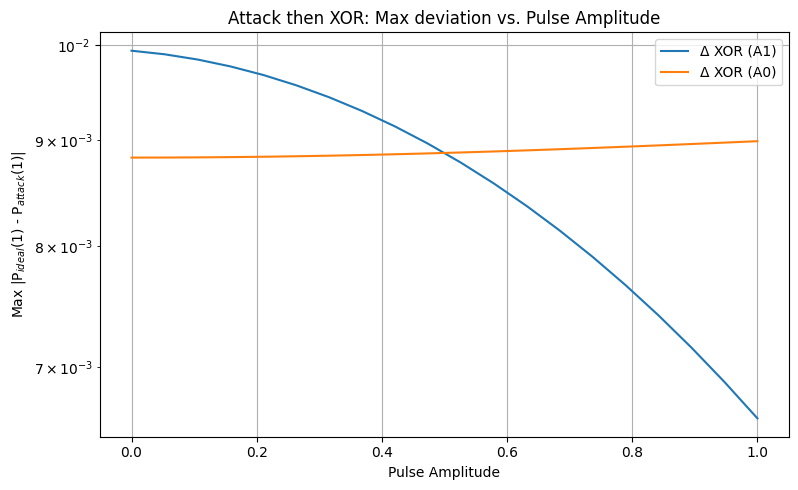

In [13]:
# Single-qubit RX rotation: Rₓ(θ) = exp(-i θ X / 2)
def Rx(theta):
    return (-1j * theta / 2 * sx).expm()

# Single-qubit RZ rotation: R_z(θ) = exp(-i θ Z / 2)
def Rz(theta):
    return (-1j * theta / 2 * sz).expm()


# === XOR Circuit ===

def build_xor_state(x1, x2):
    H = (sx + sz) / np.sqrt(2)
    psi = qt.basis(2, 0)
    psi = H * psi

    theta1 = np.pi
    theta2 = np.pi
    alpha = -np.pi / 2

    # Phase rotations:
    RZ = Rz(x1 * theta1 + alpha)
    RX = Rx(x2 * theta2 + alpha)

    psi = RZ * psi
    psi = RX * psi

    zero = qt.basis(2, 0)
    return qt.tensor(zero, zero, psi)

# === Measure ===

def xor_ideal(x1, x2):
    state = build_xor_state(x1, x2)
    P1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    P1_q2 = qt.tensor(I,I, P1)
    prob = qt.expect(P1_q2, state)
    return prob


def xor_with_attack_before(x1, x2, J12=0.1, J01=0.1, A=(0.5, 0.5)):
    # Start with all zero
    state_pre = qt.tensor(qt.basis(2,0), qt.basis(2,0), qt.basis(2,0))
    
    # Apply Eve's pulses BEFORE logical circuit
    attacked = apply_eve_multi_attack(state_pre, J12=J12, J01=J01, A=A)
    
    
    # Now apply XOR gates only to q2:
    # Hadamard:
    H = (sx + sz)/np.sqrt(2)
    H_q2 = qt.tensor(I, I, H)
    attacked = H_q2 * attacked
    
    # Parametric rotations:
    theta1 = np.pi
    theta2 = np.pi
    alpha = -np.pi/2
    RZ = qt.tensor(I, I, Rz(x1*theta1 + alpha))
    RX = qt.tensor(I, I, Rx(x2*theta2 + alpha))
    
    attacked = RZ * attacked
    attacked = RX * attacked
    
    # Measure q2
    P1 = qt.basis(2,1) * qt.basis(2,1).dag()
    P1_q2 = qt.tensor(I, I, P1)
    prob = qt.expect(P1_q2, attacked)
    return prob


# === Sweep ===

A1_vals = np.linspace(0, 1, 20)
max_devs0 = []
max_devs = []

for A1 in A1_vals:
    devs = []
    for x1, x2 in [(0,0), (0,1), (1,0), (1,1)]:
        p_ideal = xor_ideal(x1, x2)
        p_attack = xor_with_attack_before(x1, x2, J12=0.1, J01=0.1, A=(0.5, A1))
        devs.append(abs(p_ideal - p_attack))
    max_devs.append(max(devs))

for A1 in A1_vals:
    devs = []
    for x1, x2 in [(0,0), (0,1), (1,0), (1,1)]:
        p_ideal = xor_ideal(x1, x2)
        p_attack = xor_with_attack_before(x1, x2, J12=0.1, J01=0.1, A=(A1, 0.5))
        devs.append(abs(p_ideal - p_attack))
    max_devs0.append(max(devs))

# === Plot ===

plt.figure(figsize=(8, 5))
plt.plot(A1_vals, max_devs, label="Δ XOR (A1)")
plt.plot(A1_vals, max_devs0, label="Δ XOR (A0)")
plt.xlabel('Pulse Amplitude')
plt.ylabel('Max |P$_{ideal}$(1) - P$_{attack}$(1)|')
plt.title('Attack then XOR: Max deviation vs. Pulse Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.yscale('log')
plt.savefig("XORAttackInit.png", dpi=1000)
plt.savefig("XORAttackInit.svg")
plt.show()


SQQNN

In [14]:
import json
from itertools import combinations_with_replacement

def manual_poly_features(X, degree):
    """Manually generates polynomial features for a given dataset."""
    n_samples, n_features = X.shape
    
    def get_combinations():
        for d in range(degree + 1):
            for combo in combinations_with_replacement(range(n_features), d):
                yield combo

    n_output_features = sum(1 for _ in get_combinations())
    poly_X = np.empty((n_samples, n_output_features), dtype=X.dtype)
    
    for i, combo in enumerate(get_combinations()):
        poly_X[:, i] = np.prod(X[:, combo], axis=1)
        
    return poly_X

def manual_accuracy_score(y_true, y_pred):
    """Calculates accuracy."""
    return np.sum(y_true == y_pred) / len(y_true)


def manual_classification_report(y_true, y_pred, target_names):
    """Generates a classification report."""
    report = "              precision    recall  f1-score   support\n\n"
    for i, label in enumerate(np.unique(y_true)):
        tp = np.sum((y_true == label) & (y_pred == label))
        fp = np.sum((y_true != label) & (y_pred == label))
        fn = np.sum((y_true == label) & (y_pred != label))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        support = np.sum(y_true == label)
        
        class_name = target_names[i]
        report += f"{class_name:>12}    {precision:8.2f}    {recall:6.2f}    {f1:6.2f}    {support:6}\n"
    
    accuracy = manual_accuracy_score(y_true, y_pred)
    report += f"\n    accuracy                          {accuracy:6.2f}    {len(y_true):6}\n"
    return report

class QuantumSQQNN:
    """
    A quantum implementation of the SQQNN for classification.
    It loads pre-trained coefficients and uses QuTiP for prediction.
    """
    def __init__(self, coefficients, K):
        self.K = K
        self.coefficients = coefficients
        self.epsilon = 1e-9
        self.initial_state = qt.basis(2, 0)
        self.measurement_op = qt.sigmaz()

    def predict(self, X_test):
        """Makes predictions by simulating the ideal (unattacked) quantum circuit."""
        predictions = []
        X_poly_test = manual_poly_features(X_test, self.K)

        for x_poly_sample in X_poly_test:
            z = np.dot(self.coefficients, x_poly_sample)
            tanh_z = np.tanh(z)
            beta = np.arccos(np.clip(tanh_z, -1 + self.epsilon, 1 - self.epsilon))
            
            rotation_op = Ry(beta)
            final_state = rotation_op * self.initial_state
            quantum_output = qt.expect(self.measurement_op, final_state)
            
            predicted_class = np.sign(quantum_output)
            predictions.append(predicted_class)

        return np.array(predictions)

    def predict_with_attack(self, X_test,
                            J12=0.5, J01=0.5,
                            A=(0.5, 0.5), delta=(0.0, 0.0),
                            coup_12=(qt.sigmaz(), qt.sigmax()),
                            coup_01=(qt.sigmaz(), qt.sigmax()),
                            shape=("cos", "cos"),
                            extra_params=({}, {})):
        """Makes predictions simulating an attack from an eavesdropper (Eve)."""
        predictions = []
        X_poly_test = manual_poly_features(X_test, self.K)

        for x_poly_sample in X_poly_test:
            z = np.dot(self.coefficients, x_poly_sample)
            tanh_z = np.tanh(z)
            beta = np.arccos(np.clip(tanh_z, -1 + self.epsilon, 1 - self.epsilon))

            # === Build initial 3-qubit state: |Eve_Q0>|Eve_Q1>|System_Q2> ===
            # Eve's qubits start in |0>, the system qubit is prepared in Ry(β)|0>
            state_init = qt.tensor(qt.basis(2, 0), qt.basis(2, 0), qt.basis(2, 0))


            # === Apply Eve's pulse attack ===
            state_post_attack = apply_eve_multi_attack(
                state_init,
                J12=J12, J01=J01, A=A, delta=delta,
                coup_12=coup_12, coup_01=coup_01,
                shape=shape, extra_params=extra_params
            )

            # === Trace out Eve's qubits (0 and 1) to get the system's final state ===
            state_q2_biased = state_post_attack.ptrace(2)
            state_q2_final = Ry(beta) * state_q2_biased
            
            # === Measure the system qubit ===
            quantum_output = qt.expect(self.measurement_op, state_q2_final)
            predicted_class = np.sign(quantum_output)
            predictions.append(predicted_class)

        return np.array(predictions)

# --- Main execution ---
if __name__ == "__main__":
    try:
        # 1. Load data, coefficients, and parameters
        X_test = np.loadtxt("X_test.csv", delimiter=",")
        y_test = np.loadtxt("y_test.csv", delimiter=",")
        coefficients = np.load("coefficients.npy")
        with open("model_params.json", 'r') as f:
            K = json.load(f)['K']
        print("Successfully loaded all necessary files.")
        
        # 2. Initialize the Quantum Classifier
        q_classifier = QuantumSQQNN(coefficients=coefficients, K=K)

        # 3. Make Predictions WITHOUT attack
        print("\n--- Running Prediction on Ideal (No Attack) Quantum Circuit ---")
        y_pred_ideal = q_classifier.predict(X_test)
        accuracy_ideal = manual_accuracy_score(y_test, y_pred_ideal)
        report_ideal = manual_classification_report(y_test, y_pred_ideal, target_names=['Setosa (-1)', 'Versicolor (1)'])
        print(f"Accuracy (Ideal): {accuracy_ideal:.4f}")
        print("\nClassification Report (Ideal):")
        print(report_ideal)

    except FileNotFoundError:
        print("Error: Data files not found.")

Successfully loaded all necessary files.

--- Running Prediction on Ideal (No Attack) Quantum Circuit ---
Accuracy (Ideal): 1.0000

Classification Report (Ideal):
              precision    recall  f1-score   support

 Setosa (-1)        1.00      1.00      1.00        15
Versicolor (1)        1.00      1.00      1.00        15

    accuracy                            1.00        30



In [15]:
# === Attack parameters ===
A_attack = (0.5, 0.5)
shape_attack = ("cos", "cos")

# Predict under attack
y_pred_attack = q_classifier.predict_with_attack(X_test)

# Evaluate
acc_attack = manual_accuracy_score(y_test, y_pred_attack)
report_attack = manual_classification_report(
    y_test, y_pred_attack, target_names=['Setosa (-1)', 'Versicolor (1)']
)

print("\n=== SQQNN under Pulse-Level Attack ===")
print(f"Accuracy under attack: {acc_attack:.4f}")
print(report_attack)



=== SQQNN under Pulse-Level Attack ===
Accuracy under attack: 0.5000
              precision    recall  f1-score   support

 Setosa (-1)        0.00      0.00      0.00        15
Versicolor (1)        0.50      1.00      0.67        15

    accuracy                            0.50        30



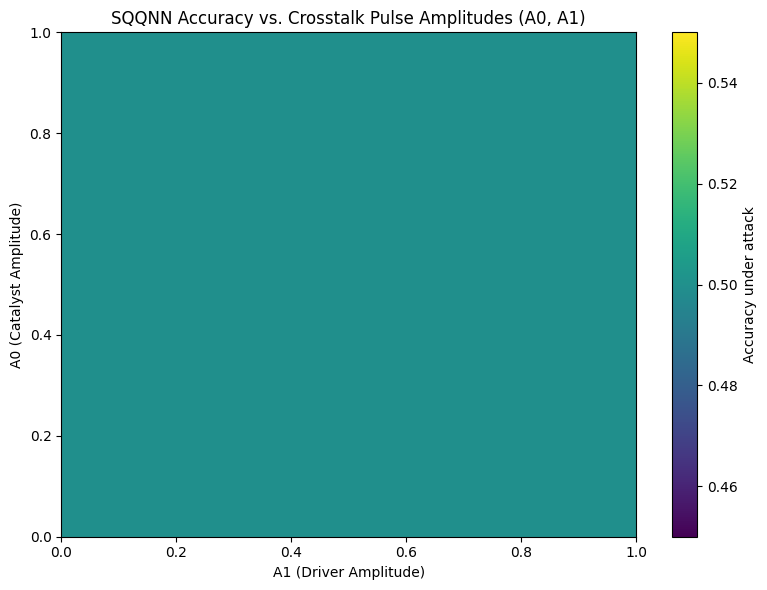

In [ ]:
A0_vals = np.linspace(0, 1, 10)
A1_vals = np.linspace(0, 1, 10)

results = []

# === Loop ===
for A0 in A0_vals:
    for A1 in A1_vals:
        y_pred_attack = q_classifier.predict_with_attack(
            X_test,
            A=(A0, A1),
            J12=0.5, J01=0.5,
            coup_12=(qt.sigmaz(), qt.sigmax()),
            coup_01=(qt.sigmaz(), qt.sigmax()),
            shape=("cos", "cos"),
            extra_params=({}, {})
        )
        acc_attack = manual_accuracy_score(y_test, y_pred_attack)
        results.append({'A0': A0, 'A1': A1, 'accuracy': acc_attack})

# === Save to DataFrame ===
df = pd.DataFrame(results)
df.to_csv("sqqnn_attack_sweep.csv", index=False)

# === Pivot for heatmap ===
pivot = df.pivot(index="A0", columns="A1", values="accuracy")

plt.figure(figsize=(8,6))
im = plt.imshow(pivot, origin='lower', extent=[A1_vals.min(), A1_vals.max(), A0_vals.min(), A0_vals.max()],
                aspect='auto', cmap='viridis')
plt.colorbar(im, label="Accuracy under attack")
plt.xlabel("A1 (Driver Amplitude)")
plt.ylabel("A0 (Catalyst Amplitude)")
plt.title("SQQNN Accuracy vs. Crosstalk Pulse Amplitudes (A0, A1)")
plt.tight_layout()
plt.savefig("SQQNN_AttackSweep.png", dpi=1000)
plt.show()